# José Luis Padilla Valenzuela

## Clasificación de Tweets en Español (Análisis de Sentimientos)

* Este ejercicio consiste en clasificar una serie de tweets en Español que estan clasificados como '***positivos***', '***neutros***', '***negativos***' o '***None***' (desconocido), aunque solo vamos a trabajar con los tweets clasificados correctamente (los no desconocidos).

<hr>


## Carga de Datos


* El primer paso que vamos a realizar es el de cargar los datos. 


* Estos datos estan en un archivo con extensión '*txt*' pero tienen estructura de '*csv*' y tienen como separador '***::::***'.


* Este fichero lo podemos leer como un '*csv*' con pandas, estructurándolo de la siguiente manera:
    - **Posición 0**: Tweet
    - **Posición 1**: Sentimiento (Positivo | Neutro | Negativo)
    
    
* Los tweets estan clasificados con 4 etiquetas, pero vamos a trabajar solo con los tweets que sean '***positivos***', '***neutros***' o '***negativos***'.

In [1]:
import pandas as pd
tweets_file = 'C:\\Users\\jlpad\Desktop\\BBDD\\tweets_castellano.txt'
df = pd.read_csv(tweets_file, sep = "::::", names = ['tweet','sentimiento'] ,engine = 'python')
df = df[df['sentimiento'].isin(['positivo', 'neutro', 'negativo'])]
tweets = [tuple(x) for x in df.values]
print('Número de Tweets Cargados: {num}'.format(num = len(tweets)))
df.head(5)

Número de Tweets Cargados: 5735


,tweet,sentimiento
1,@PauladeLasHeras No te libraras de ayudar me/n...,neutro
2,@marodriguezb Gracias MAR,positivo
3,"Off pensando en el regalito Sinde, la que se v...",negativo
4,Conozco a alguien q es adicto al drama! Ja ja ...,positivo
6,Toca @crackoviadeTV3 . Grabación dl especial N...,positivo


<hr>


## Normalización

* Para este ejercicio haremos uso de ***spaCy*** para la tokenización y normalización.


* Para ***normalizar*** los tweets realizaremos las siguientes acciones:
    1. Pasamos las frases a minúsculas.
    2. Eliminamos los signos de puntuación.
    3. Eliminamos las palabras con menos de 3 caracteres.
    4. Eliminamos las Stop-Words.
    5. Eliminamos los enlaces (vamos a dejar las menciones '@'.
    6. Pasamos la palabra a su lema


* Todos estos pasos los vamos a realizar en una misma función.

In [2]:
import spacy
nlp = spacy.load('es_core_news_sm')

# Divido los datos en dos listas 
#     X: los tweets
#     y: target (polaridad)

X = [doc[0] for doc in tweets]
y = [doc[1] for doc in tweets]

def normalize(sentenses):
    """normalizamos la lista de frases y devolvemos la misma lista de frases normalizada"""
    for index, sentense in enumerate(sentenses):
        sentense = nlp(sentense.lower()) # Paso la frase a minúsculas y a un objeto de la clase Doc de Spacy
        sentenses[index] = " ".join([word.lemma_ for word in sentense if (not word.is_punct)
                                     and (len(word.text) > 2) and (not word.is_stop) 
                                     and (not word.text.startswith('http'))])
    return sentenses

# Normalizamos las frases
X = normalize(X)

<hr>


## Bolsa de Palabras de Frecuencias


* El siguiente paso es transformar los tweets a una bolsa de palabras de frecuencias para que sirva de entrada al modelo.


* Vamos a utilizar (para construir la bolsa de palabras) la clase "*CountVectorizer*" de scikit, quedandonos con:
    - Las 1500 palabras más frecuentes.
    - Que las palabras aparezcan por los menos en 3 tweets.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1500, min_df=3)

# Pasamos los tweets normalizados a Bolsa de palabras
X = vectorizer.fit_transform(X)

<hr>


## Particionado de Datos (Train y Test)

* Particionar los datos en conjunto de Train y Test de la siguiente manera:
    - 80% de datos de entrenamiento
    - 20% de datos de test


In [4]:
from sklearn.model_selection import train_test_split  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print('Número de Tweets para el entrenamiento: {num}'.format(num = X_train.shape[0]))
print('Número de Tweets para el test: {num}'.format(num = X_test.shape[0]))

Número de Tweets para el entrenamiento: 4588
Número de Tweets para el test: 1147


<hr>


## Creacción del Modelo

* Vamos a crear una serie de modelos con los siguientes Algoritmos de Aprendizaje de clasificación:

    - Multinomial Naive Bayes
    - Bernoulli Naive Bayes
    - Regresion Logistica
    - Support Vector Machine
    - Random Forest

In [5]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

mnb = MultinomialNB()
bnb = BernoulliNB()
lr = LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial', max_iter = 1000)
svm_lin = SVC(kernel = 'linear')
svm_rbf = SVC(kernel = 'rbf')
rf = RandomForestClassifier(n_estimators = 200, bootstrap = True, criterion = 'gini', max_depth = 50, random_state = 0)

clasificadores = {'Multinomial Naive Bayes': mnb,
                  'Bernoulli Naive Bayes': bnb,
                  'Regresion Logistica': lr,
                  'SVM lineal': svm_lin,
                  'SVM rbf': svm_rbf,
                  'Random Forest': rf}


# Ajustamos los modelos y calculamos el accuracy para los datos de entrenamiento
for k, v in clasificadores.items():
    print ('CREANDO MODELO: {clas}'.format(clas = k))
    v.fit(X_train, y_train)
    accuracy_train = v.score(X_train, y_train)
    print ('\tAccuracy Train: {acc_train}'.format(acc_train = accuracy_train)) 

CREANDO MODELO: Multinomial Naive Bayes
	Accuracy Train: 0.7659110723626853
CREANDO MODELO: Bernoulli Naive Bayes
	Accuracy Train: 0.7554489973844812
CREANDO MODELO: Regresion Logistica
	Accuracy Train: 0.8297733217088056
CREANDO MODELO: SVM lineal
	Accuracy Train: 0.8408892763731474
CREANDO MODELO: SVM rbf
	Accuracy Train: 0.8681342632955537
CREANDO MODELO: Random Forest
	Accuracy Train: 0.7720139494333043


<hr>


## Evaluación del Modelo

* Para cada uno de los modelos vamos a calcular las siguientes métricas de evaluación:

    1. **Accuracy**
    2. **Precision**
    3. **Recall**
    4. **F1**


In [6]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score

def evaluation(model, name, X_train, y_train, X_test, y_test):
    """
    Función de devuelve en un diccionario las métricas de evaluación de 
    Accuracy, Precision, Recall y F1 para los conjuntos de datos de entrenamiento y test
        model: modelo a evaluar
        name: nombre del modelo
        X_train: Variables de entrada del conjunto de datos de entrenamiento
        y_train: Variable de salida del conjunto de datos de entrenamiento
        X_test: Variables de entrada del conjunto de datos de test
        y_test: Variable de salida del conjunto de datos de test
        return: diccionario con el nombre del modelo y el valor de las métricas
    """
    model_dict = {}
    model_dict['name'] = name
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    model_dict['accuracy_train'] = accuracy_score(y_true = y_train, y_pred = y_pred_train)
    model_dict['accuracy_tests'] = accuracy_score(y_true = y_test, y_pred = y_pred_test)
    model_dict['precision_train'] = precision_score(y_true = y_train, y_pred = y_pred_train, average = 'weighted')
    model_dict['precision_tests'] = precision_score(y_true = y_test, y_pred = y_pred_test, average = 'weighted')
    model_dict['recall_train'] = recall_score(y_true = y_train, y_pred = y_pred_train, average = 'weighted')
    model_dict['recall_tests'] = recall_score(y_true = y_test, y_pred = y_pred_test, average = 'weighted')
    model_dict['f1_train'] = f1_score(y_true = y_train, y_pred = y_pred_train, average = 'weighted')
    model_dict['f1_tests'] = f1_score(y_true = y_test, y_pred = y_pred_test, average = 'weighted')
    
    return model_dict


# Calculamos las métricas de los modelos por separado
evaluacion = list()
for key, model in clasificadores.items():
    evaluacion.append(evaluation(model = model, name = key, 
                                 X_train = X_train, y_train = y_train,
                                 X_test = X_test, y_test = y_test))

# Pasamos los resultados a un DataFrame para visualizarlos mejor
results = pd.DataFrame.from_dict(evaluacion)
results.set_index("name", inplace = True)
results

,accuracy_train,accuracy_tests,precision_train,precision_tests,recall_train,recall_tests,f1_train,f1_tests
name,,,,,,,,
Multinomial Naive Bayes,0.765911,0.679163,0.761379,0.659119,0.765911,0.679163,0.756321,0.665681
Bernoulli Naive Bayes,0.755449,0.673932,0.750163,0.646144,0.755449,0.673932,0.741758,0.654333
Regresion Logistica,0.829773,0.649520,0.831923,0.623103,0.829773,0.649520,0.819576,0.631668
SVM lineal,0.840889,0.635571,0.844903,0.620002,0.840889,0.635571,0.833394,0.626315
SVM rbf,0.868134,0.675676,0.881187,0.602145,0.868134,0.675676,0.853746,0.635426
Random Forest,0.772014,0.634699,0.834700,0.569999,0.772014,0.634699,0.751640,0.586995


* Representamos las métricas para los diferentes modelos en un gráfico de barras:

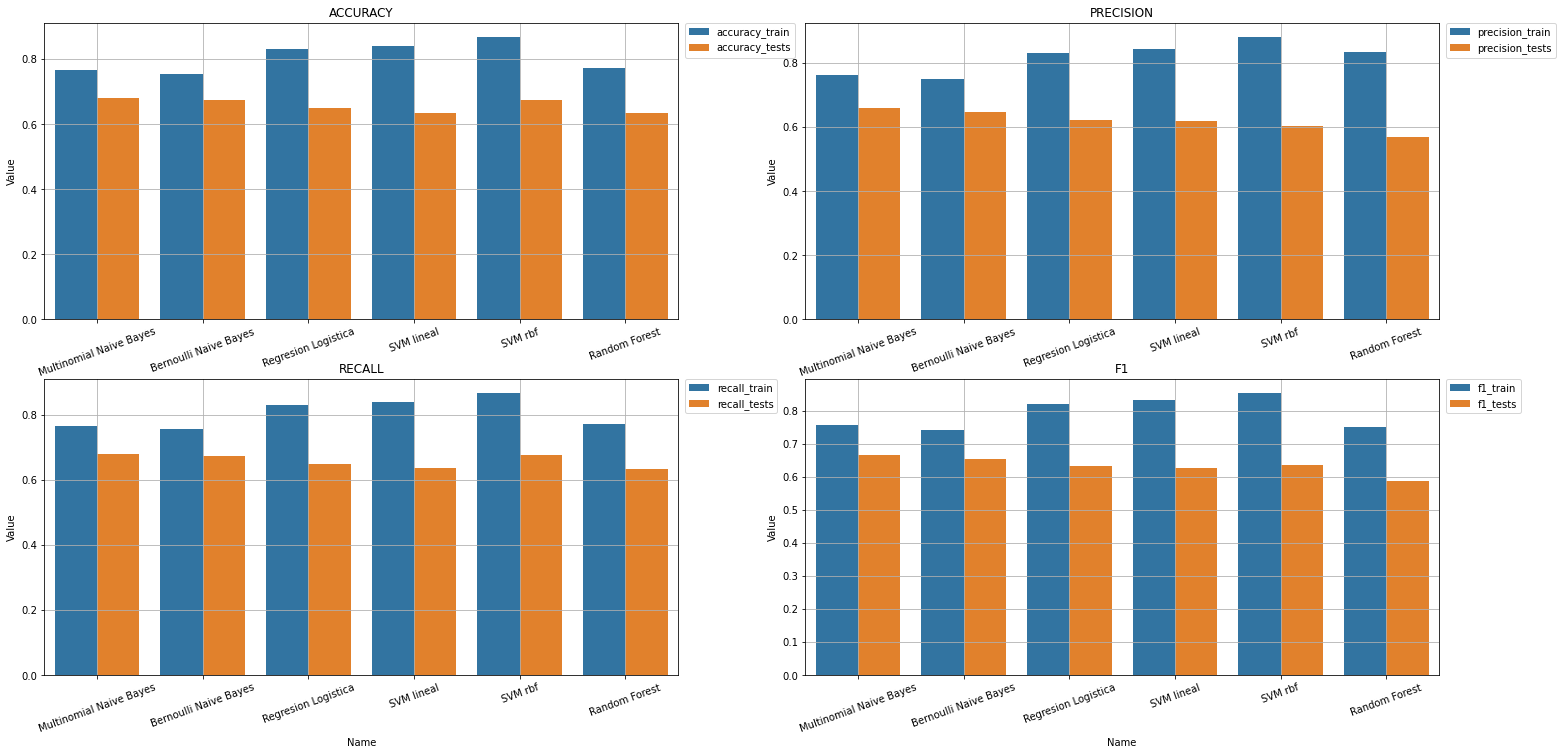

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Métricas a pintar
METRICS = ["accuracy", "precision", "recall", "f1"]

# Transformamos el dataframe para pintar las gráficas con seaborn
df_plot = results.reset_index().melt(id_vars = 'name').rename(columns = str.title)

plt.figure(figsize = (25, 12))
pos = 1
for metric in METRICS:
    # Filtramos la métrica a pintar
    df_aux = df_plot[df_plot['Variable'].str.contains(metric)]
    
    # Pintamos la gráfica en su posición 2x2
    plt.subplot(2, 2, pos)
    sns.barplot(x = 'Name', y = 'Value', hue = 'Variable', data = df_aux)
    plt.title(metric.upper())
    plt.grid()
    plt.legend(bbox_to_anchor = (1.01, 1), loc = 2, borderaxespad = 0.)
    plt.xticks(rotation = 20)
    pos += 1
plt.show()

* Vamos a dibujar las matrices de confusión obtenidas para cada uno de los modelos creados:

Obteniendo Matriz de Confusión de: Multinomial Naive Bayes
Obteniendo Matriz de Confusión de: Bernoulli Naive Bayes
Obteniendo Matriz de Confusión de: Regresion Logistica
Obteniendo Matriz de Confusión de: SVM lineal
Obteniendo Matriz de Confusión de: SVM rbf
Obteniendo Matriz de Confusión de: Random Forest


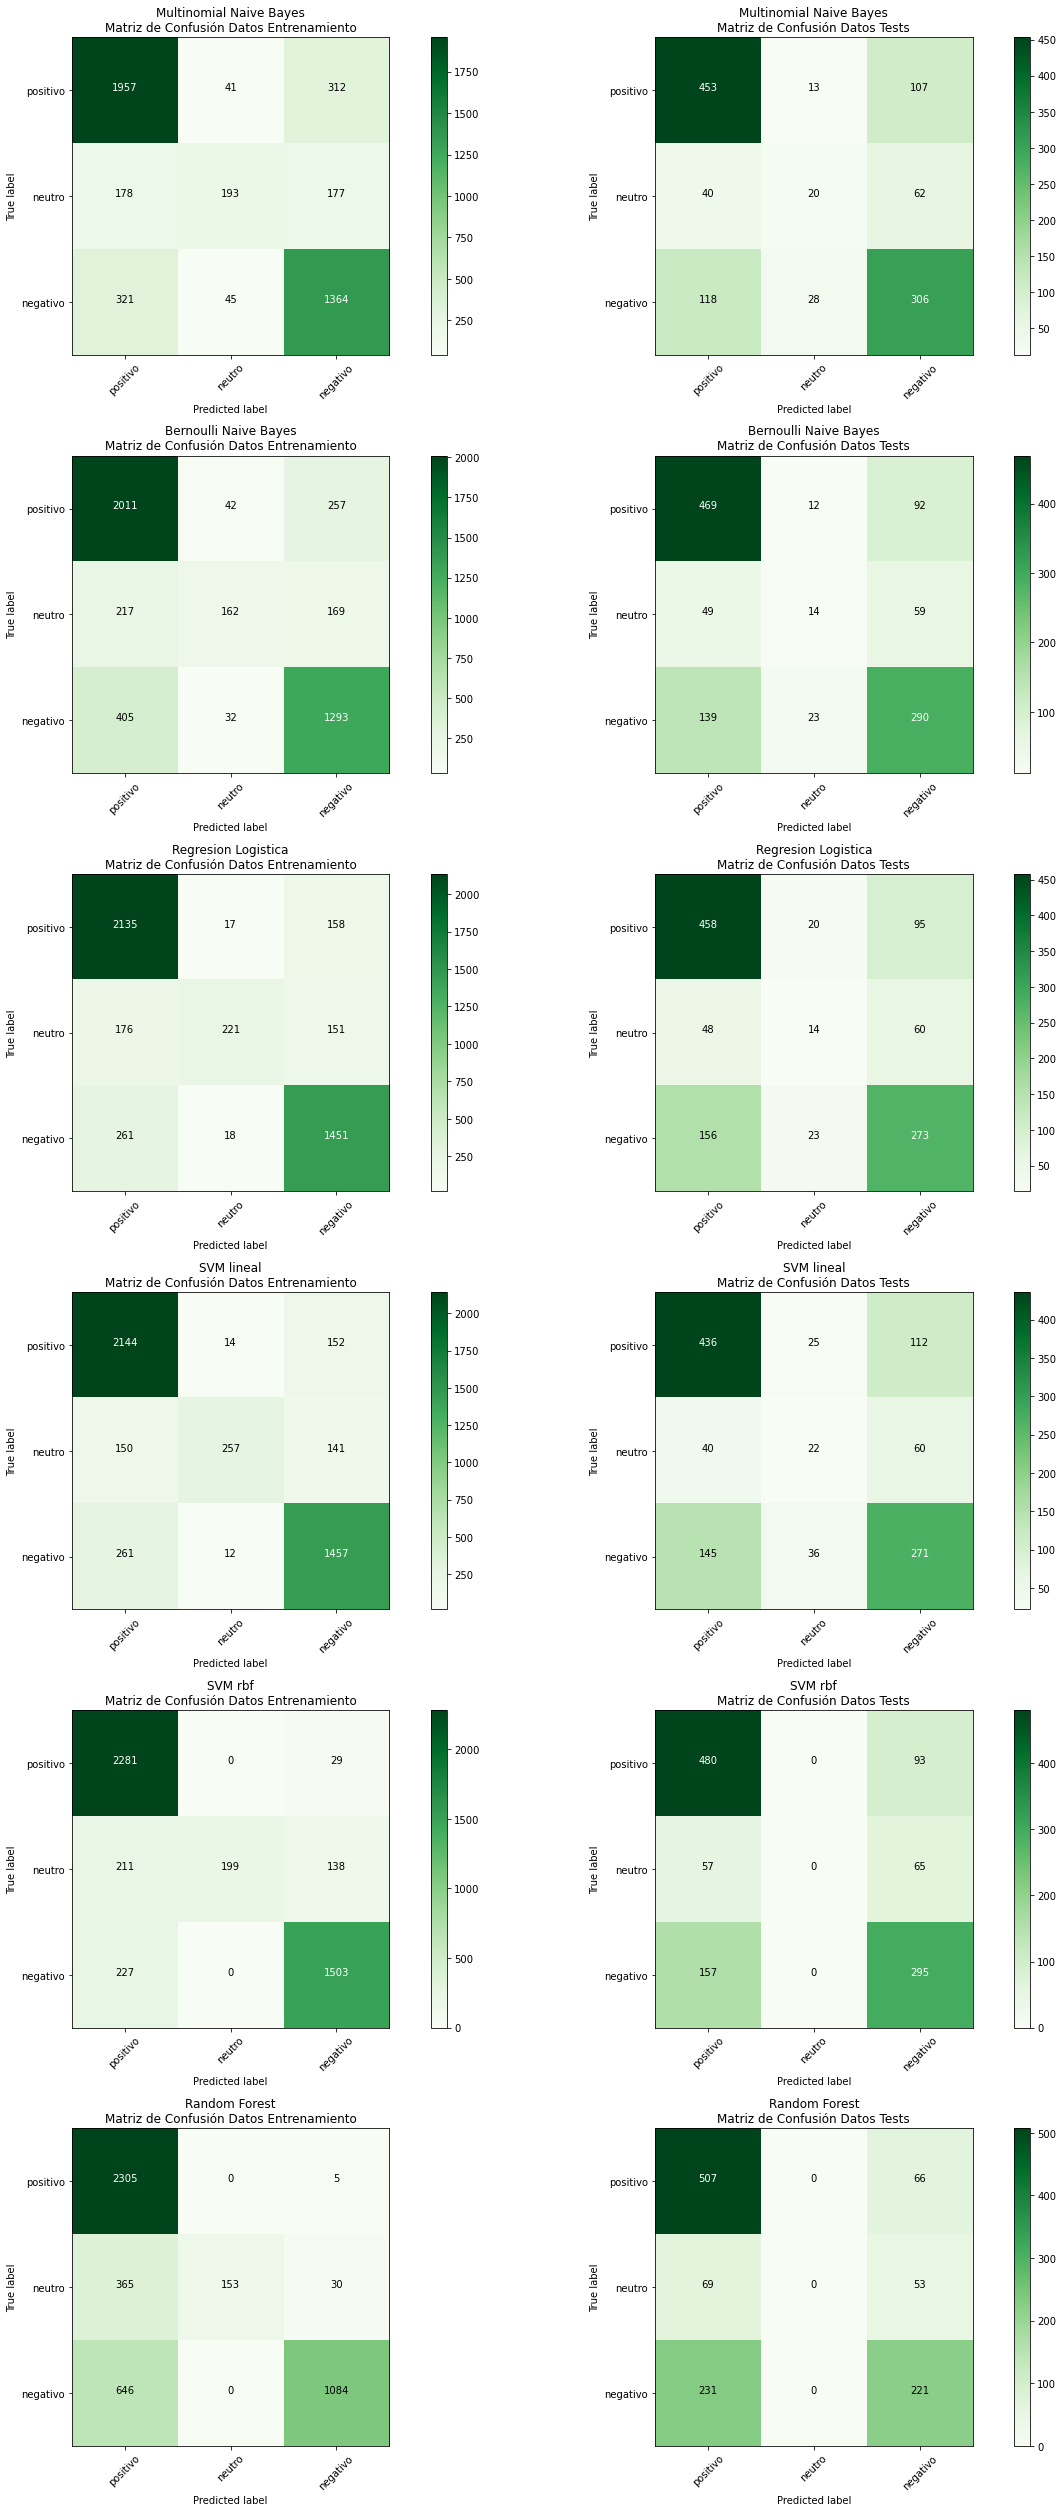

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

from sklearn.metrics import confusion_matrix

polaridad = ['positivo', 'neutro', 'negativo']

# Obtenemos las Matrices de confusión
msc = list()
for k, v in clasificadores.items():
    print ('Obteniendo Matriz de Confusión de: {model}'.format(model=k))
    model = {}
    model['name'] = k
    y_pred_train = v.predict(X_train)
    y_pred_test = v.predict(X_test)
    model['confusion_matrix_train'] = confusion_matrix(y_true = y_train, y_pred = y_pred_train, labels = polaridad)
    model['confusion_matrix_test'] = confusion_matrix(y_true = y_test, y_pred = y_pred_test, labels = polaridad)
    msc.append(model)

    
# Definimos el heatmap de la matriz de confusión
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Pintamos las matrices de confusión
plt.figure(figsize = (20, 35))
pos = 0
for mc in msc:
    pos += 1
    plt.subplot(6, 2, pos)
    plot_confusion_matrix(mc['confusion_matrix_train'], classes = polaridad, 
                          title = '{}\nMatriz de Confusión Datos Entrenamiento'.format(mc['name']))
    pos += 1
    plt.subplot(6, 2, pos)
    plot_confusion_matrix(mc['confusion_matrix_test'], classes = polaridad, 
                          title = '{}\nMatriz de Confusión Datos Tests'.format(mc['name'] ))
plt.show()